# Principal component analysis

This notebook illustrate how to analyze IDP ensembles in IDPET via [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

Note that other dimensionality reduction methods in IDPET follow similar concepts. For method-specific behavior, please refer to the corresponding notebooks.

For an overview of dimensionality reduction methods in IDPET, please also refer to a [related Demo](https://hamidrgh.github.io/gh_pages_idpet/dr_phipsi.html) in the documentation.

## Download from PED and load data

Let's download three different ensembles for the same protein (drkN SH3 domain) from PED.

In [3]:
from idpet.ensemble import Ensemble
from idpet.ensemble_analysis import EnsembleAnalysis
from idpet.visualization import Visualization


# Initialize the ensemble objects.
ensembles = [
    Ensemble('PED00156e001', database='ped'),
    Ensemble('PED00157e001', database='ped'),
    Ensemble('PED00158e001', database='ped')
    
]

# Will download ensemble data from PED or load it from a local cache.
analysis = EnsembleAnalysis(ensembles)
analysis.load_trajectories();

## Featurization

The first step of dimensionality reduction in IDPET is the featurization of molecular conformations into a set of structural features.

We will featurize ensembles by representing their conformations as the set of their Ca-Ca distances.

In [4]:
features = analysis.extract_features(featurization='ca_dist')

The features are stored internally as numpy arrays in the `EnsembleAnalysis` object, but they are also returned as a dictionary by its `extract_features` method. In this way, we can manually inspect them if we need to, as illustrated below.

In [5]:
for ensemble_name_i in features:
    features_i = features[ensemble_name_i]
    print(f"Average Ca-Ca distance in {ensemble_name_i}: {features_i.mean():.4f} nm")

Average Ca-Ca distance in PED00156e001: 2.2903 nm
Average Ca-Ca distance in PED00157e001: 2.4064 nm
Average Ca-Ca distance in PED00158e001: 2.3446 nm


## Dimensionality reduction

Next, we will perform PCA on the features that we computed. In this way we can embed each conformation in a lower-dimensional space.

As the raw features are internally stored in the `EnsembleAnalysis` object, we can directly call the `reduce_features` method of the `EnsembleAnalysis` object to perform dimensionality reduction. The `method` argument decides the type of dimensionality reduction method, here we will use PCA.

In [6]:
analysis.reduce_features(
    method='pca',
    n_components=10  # Maximum number of dimensions to use.
);

The output PCA coordinates will be stored internally in the `EnsembleAnalysis`. We can access the PCA coordinates of all ensembles directly if needed, via the `reduce_dim_data` attribute of the object.

In [7]:
for ensemble_name_i in analysis.reduce_dim_data:
    pca_data_i = analysis.reduce_dim_data[ensemble_name_i]
    print(f"PCA data for {ensemble_name_i} is an array of shape: {pca_data_i.shape}")

PCA data for PED00156e001 is an array of shape: (100, 10)
PCA data for PED00157e001 is an array of shape: (100, 10)
PCA data for PED00158e001 is an array of shape: (88, 10)


## Analysis

Let's begin a visual analysis of the PCA results.

In [8]:
visualization = Visualization(analysis)

We will first plot the cumulative variance of the data at each principal component (PC).

For highly disordered IDPs, the first few principal components rarely account for a large proportion of the total variance. This reflects their high conformational heterogeneity and polymer-like ensemble.

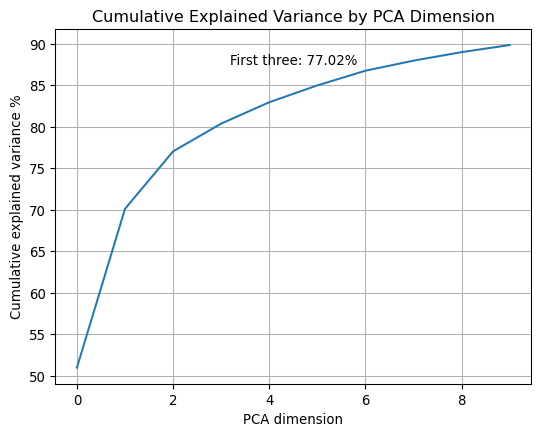

In [9]:
visualization.pca_cumulative_explained_variance();

### Plot 2D Landscapes

We can quickly visualize the PCA projections of all ensembles via the `pca_2d_landscapes` method of the `Visualization` class.

Each datapoint corresponds to a molecular conformation.

Clearly, conformations from the first ensemble (PED00156) map in different regions of the space defined by the first two PCs.

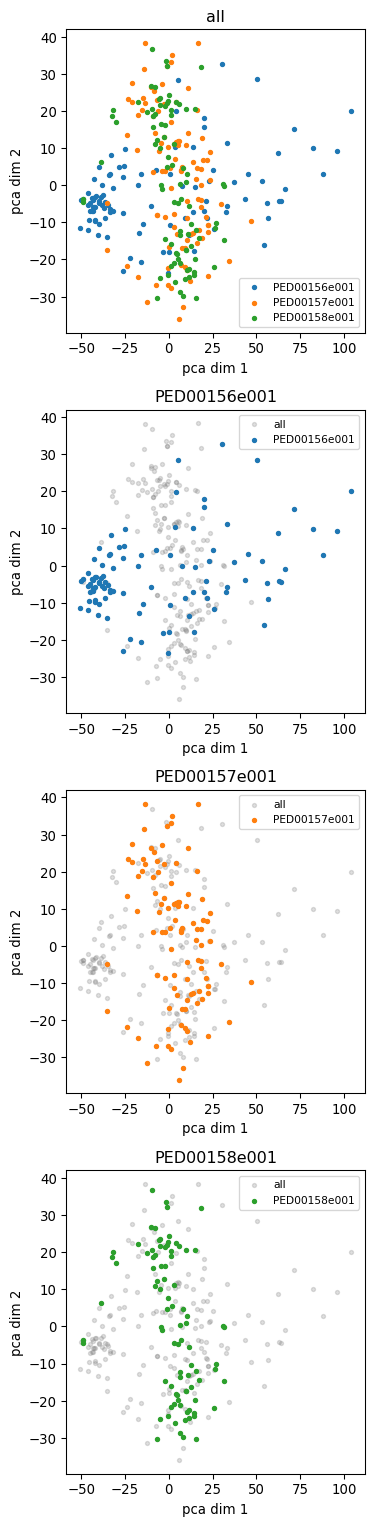

In [10]:
# Dimensionality reduction features we want to analyze, with indices starting from 0.
sel_dims = [0, 1]
visualization.pca_2d_landscapes(sel_components=sel_dims);

### 1D Histograms

We can also visualize the marginal histograms of each principal component via the `pca_1d_histograms` method of the `Visualization` class.

The histograms confirm the results from above: along the first PC, PED00156 conformers have a different distribution.

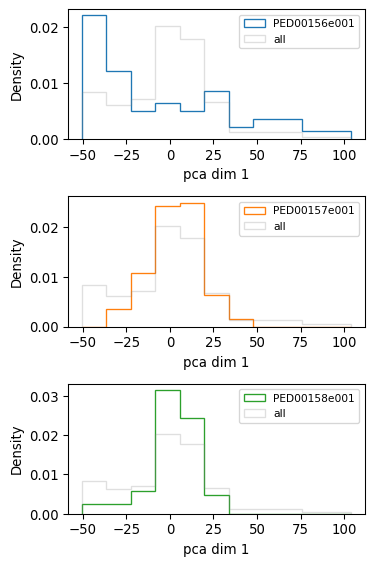

In [11]:
sel_dim = 0  # First principal component.
visualization.pca_1d_histograms(sel_components=sel_dim, bins=12);

### Is PC 1 from Ca-Ca correlated with radius of gyration?

A hallmark of highly disordered ensembles is that when performing PCA on Ca–Ca distances, the first principal component (PC1) is often strongly correlated with the radius of gyration (Rg). In other words, the collective motion with the largest variance typically captures changes in chain compactness. This behavior is also observed in the drkN SH3 ensembles.

The `pca_rg_correlation` of the `Visualization` class allows us to directly analyze this correlation.

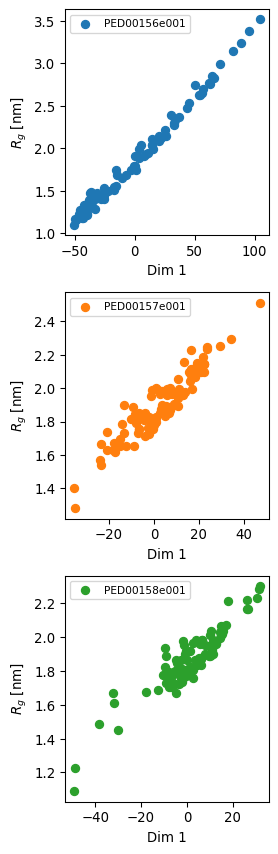

In [14]:
sel_dim = 0
visualization.pca_rg_correlation(sel_components=sel_dim);

This is highlighted also by the distribution of Rg in the ensembles, which is really similar to the one along the first PC that we analyzed above, when we used the `pca_1d_histograms` method.

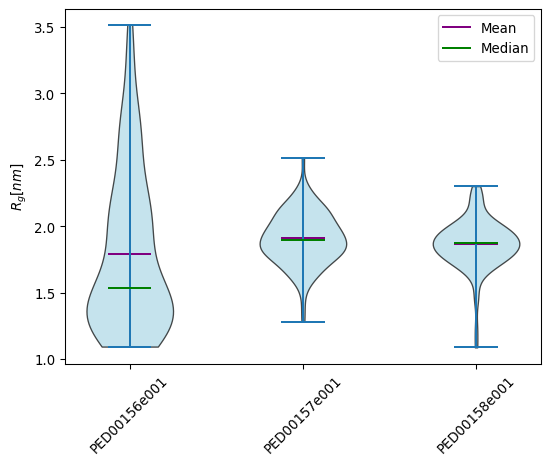

In [16]:
visualization.radius_of_gyration(bins=12, summary_stat='both');

We can further confirm this behavior by inspecting the PC weights (loadings) associated with each input feature, that is, each Ca–Ca distance.

As shown in the plot below, end-to-end distances contribute strongly to PC1, indicating that the dominant mode of motion corresponds to global compaction and expansion of the polymer chain. Subsequent PCs capture independent modes of motion, such as compaction/expansion of subsegments. This hierarchical variance pattern is characteristic of highly disordered ensembles.

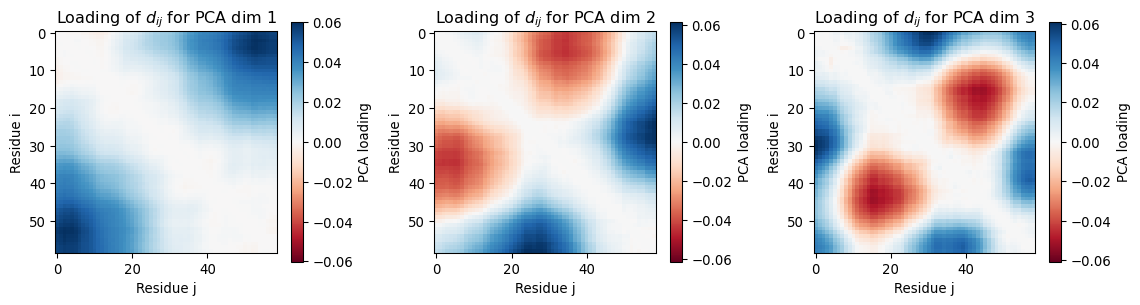

In [17]:
sel_dims = [0, 1, 2]
visualization.pca_residue_correlation(sel_components=sel_dims);